In [1]:
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
template_file = open('../template_script/egsea_template.R', 'r')
template_file_info = template_file.read()
template_file.close()

In [25]:
# load gene expression files in raw read count matrix format
expr_dir = '../data/count_matrix/'
all_file = os.listdir(expr_dir)
all_file.sort()
all_file

['AARS.txt',
 'AATF.txt',
 'ABCF1.txt',
 'ADAR.txt',
 'AGO1.txt',
 'AKAP1.txt',
 'AKAP8.txt',
 'AKAP8L.txt',
 'APOBEC3C.txt',
 'ASCC1.txt']

In [26]:
pathway_file = '../pathway_files/K562_DESEq2.gmt'

In [27]:
# directory for storing all output results
result_dir = '../example_results/EGSEA_results/'
# write the scripts for each target to a seperate R script to enable parallel running
script_dir = '../example_scripts/EGSEA_scripts/'

In [28]:
for expr_file in all_file:
    target = expr_file.split('.')[0]
    new_template_info = template_file_info.replace('TARGET_data_matrix.txt', expr_dir+expr_file)
    new_template_info = new_template_info.replace('pathway_file_name', pathway_file)
    new_template_info = new_template_info.replace('output_file', result_dir+target+'.egsea_result.txt')
    script = open(script_dir+target+'.r', 'w')
    script.write(new_template_info)
    script.close()        

Run the R scripts. And the results will be saved in example_results/EGSEA_results/

In [36]:
# extract EGSEA results and its underlying methods results
methods_egsea = ['EGSEA', 'camera', 'safe', 'gage', 'padog', 'plage', 
                 'zscore', 'gsva', 'ssgsea', 'ora']
all_result_file = os.listdir(result_dir)
all_result_file.sort()
rank_dict = dict()
for m in methods_egsea:
    rank_dict[m] = dict()
for file in all_result_file:
    target = file.split('.')[0]
    df = pd.read_csv(result_dir+file, sep='\t')
    df['pathway_rank'] = stat.rankdata(df['avg.rank'])
    egsea_rank = df.loc[target]['pathway_rank']
    rank_dict['EGSEA'][target] = egsea_rank
    # extract results of underlying methods of EGSEA
    for m in methods_egsea[1:]:
        df[m+'_rank'] = stat.rankdata(df[m])
        method_rank = df.loc[target][m+'_rank']
        rank_dict[m][target] = method_rank

In [41]:
rank_df = pd.DataFrame.from_dict(rank_dict)
# write the results to seperate files
for m in methods_egsea:
    rank_df[m].to_csv('../example_results/'+m+'_result.txt', sep='\t', header=None)

In [2]:
# plot all results
result_dfs = []
result_dir = '../example_results/'
methods_egsea = ['EGSEA', 'camera', 'safe', 'gage', 'padog', 'plage', 
                 'zscore', 'gsva', 'ssgsea', 'ora']
for m in methods_egsea:
    res_df = pd.read_csv(result_dir+m+'_result.txt', sep='\t', header=None, index_col=0)
    result_dfs.append(res_df)
# combine the results
all_result_df = pd.concat(result_dfs, axis=1)
all_result_df.columns = methods_egsea
all_result_df

,EGSEA,camera,safe,gage,padog,plage,zscore,gsva,ssgsea,ora
0,,,,,,,,,,
AARS,11.0,2.0,30.0,44.0,87.0,128.0,8.0,13.0,7.0,3
AATF,1.0,18.0,10.0,72.0,83.0,2.0,14.0,71.0,1.0,2
ABCF1,5.0,2.0,1.0,54.0,1.0,113.0,1.0,1.0,5.0,47
ADAR,1.0,1.0,89.0,2.0,1.0,18.0,1.0,1.0,1.0,1
AGO1,24.0,18.0,129.0,15.0,141.0,33.0,13.0,45.0,5.0,1
AKAP1,2.0,9.0,2.0,20.0,1.0,100.0,7.0,16.0,5.0,31
AKAP8,3.0,5.0,5.0,51.0,19.0,44.0,2.0,2.0,9.0,44
AKAP8L,2.0,1.0,1.0,45.0,1.0,161.0,1.0,1.0,1.0,1
APOBEC3C,10.0,7.0,33.0,11.0,29.0,47.0,2.0,2.0,1.0,67


In [3]:
def apk(predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average precision at k between two lists of items.
    """
    total_num = len(predicted)
    precision_list = []
    for idx in range(k):
        precision_list.append(np.where(predicted<=idx+1)[0].shape[0]/total_num)
        # print(np.where(predicted<=idx+1)[0].shape[0])
    # return P@10 and AP@10
    return precision_list[-1], np.mean(precision_list)

<AxesSubplot: ylabel='Ground truth pathway rank'>

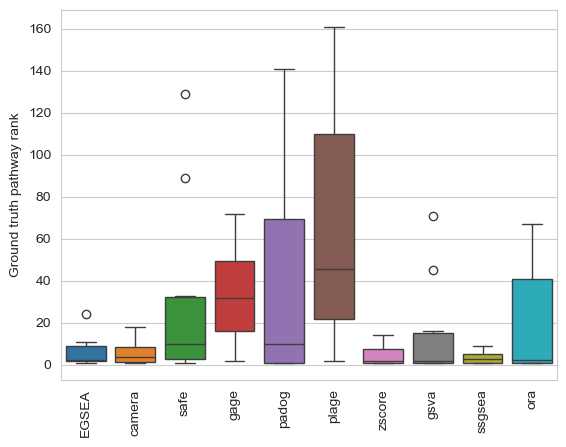

In [4]:
# plot the results
plt.xticks(rotation=90)
plt.ylabel('Ground truth pathway rank')
sns.boxplot(data=all_result_df)

<AxesSubplot: ylabel='Percent'>

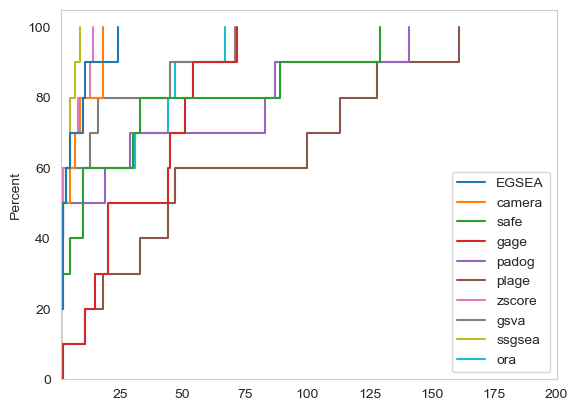

In [5]:
plt.grid(False)
plt.xlim(1, 200)
# plt.ylim(0, 100)
sns.ecdfplot(data=all_result_df, stat='percent')

In [7]:
for method in all_result_df.columns:
    print('-'*20)
    print(method, 'summary:')
    print('Median rank: ', all_result_df[method].median())
    print('Precision@10: ', apk(all_result_df[method])[0])
    print('Average Precision@10: ', apk(all_result_df[method])[1])

--------------------
EGSEA summary:
Median rank:  2.5
Precision@10:  0.8
Average Precision@10:  0.6199999999999999
--------------------
camera summary:
Median rank:  3.5
Precision@10:  0.8
Average Precision@10:  0.5999999999999999
--------------------
safe summary:
Median rank:  10.0
Precision@10:  0.6
Average Precision@10:  0.37
--------------------
gage summary:
Median rank:  32.0
Precision@10:  0.1
Average Precision@10:  0.09
--------------------
padog summary:
Median rank:  10.0
Precision@10:  0.5
Average Precision@10:  0.5
--------------------
plage summary:
Median rank:  45.5
Precision@10:  0.1
Average Precision@10:  0.09
--------------------
zscore summary:
Median rank:  2.0
Precision@10:  0.8
Average Precision@10:  0.65
--------------------
gsva summary:
Median rank:  2.0
Precision@10:  0.6
Average Precision@10:  0.5799999999999998
--------------------
ssgsea summary:
Median rank:  3.0
Precision@10:  1.0
Average Precision@10:  0.74
--------------------
ora summary:
Median rank: